In [1]:
import pandas as pd
import json
from evaluation_utils import read_global_results, ssl_method_to_category, unpivot_ssl_model, unpivot_baseline_model, read_processed_shards
from constants import RESULTS_ROOT, MODE_2_3_PROCESSED_DIR, PRELIMINARY_DIR, MODE_1_PROCESSED_DIR, MODE_2_3_MARG_PROCESSED_DIR, TEST_METRIC, ENCODERS, TRAINING_SCHEMES, SSL_MODELS, BASELINES, ENCODER_COLORS, SINGLE_ENCODER_MODELS, \
                        GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL, MODE_1_LEARNING_CURVES_DIR, model_abbreviations
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from matplotlib.ticker import PercentFormatter
from scipy.stats import f_oneway
from tqdm import tqdm
from collections import defaultdict
import scipy

In [2]:
df = read_global_results(MODE_2_3_PROCESSED_DIR)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
12.ndjson
13.ndjson
14.ndjson
15.ndjson
16.ndjson
concatenating


In [3]:
# Compute average test metric for each graph over all models
TEST_METRIC = 'test_rocauc_ovr'
cols = [col for col in df.columns if TEST_METRIC in col]
df[f'avg_{TEST_METRIC}'] = df[cols].mean(axis=1)

In [10]:
def find_default_graph_properties(data, BINS = 40):
    # ---------------- SETUP ----------------
    # Bin each graph property into a fixed number of quantile bines
    GRAPH_PROPERTIES = ['nvertex', 'avg_degree', 'feature_center_distance', 'num_clusters',
                        'cluster_size_slope', 'power_exponent', 'p_to_q_ratio', 'min_deg']
    for gp in GRAPH_PROPERTIES:
        if len(data[gp].unique()) < BINS: # If graph property has small samples, create bins centered on each integer value
            bin_edges = [b - 0.5 for b in sorted(data[gp].unique())] + [data[gp].max() + 0.5]
            bins = pd.cut(data[gp], bins=bin_edges)
        else:
            bins = pd.qcut(data[gp], q=BINS, duplicates='drop')
        data[f'bin_{gp}'] = bins

    # create an empty dictionary to store the results
    results = {}

    # Plotting setup
    colors = {}
    for i, gp in enumerate(GRAPH_PROPERTIES):
        colors[gp] = plt.cm.tab10(i)

    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,5))



    # ---------------- EXECUTION ----------------
    # loop over each graph property
    for gp, ax in zip(GRAPH_PROPERTIES, axs.reshape(-1)):
        bin_f_stats = {}
        plotting_f_stats = defaultdict(list)
        bins = sorted(data[f'bin_{gp}'].unique())

        # loop over each quantile bin of the property
        for b in bins:
            # filter the dataframe to only include rows where the current parameter is in bin i
            data_i = data[data[f'bin_{gp}'] == b]

            # compute the average F statistic between the other parameters and the test metric
            f_stats = []
            for gp_other in GRAPH_PROPERTIES:
                if gp_other != gp:
                    groups = list(data_i.groupby(f'bin_{gp_other}')[f'avg_{TEST_METRIC}'].apply(list)) # Create a group per bin
                    groups = [g for g in groups if len(g) > 0] # Remove empty groups 
                    f_stat, p_val = f_oneway(*groups)
                    f_stats.append(f_stat)
                    plotting_f_stats[gp_other].append(f_stat)        
            bin_f_stats[b] = sum(f_stats) / len(f_stats)

        # find the quantized value that produced the highest average F statistic
        max_f_stat = max(bin_f_stats, key=bin_f_stats.get)
        results[gp] = max_f_stat

        # plotting
        for k,v in plotting_f_stats.items():
            ax.scatter([b.mid for b in bins], v, color=colors[k], label=k, s=10)
        ax.axvline(x = max_f_stat.mid, color = 'black', label = 'chosen bin', linestyle='dashed')
        ax.plot([b.mid for b in bins], [f for f in bin_f_stats.values()], color='black', label="average f stat")
        ax.title.set_text(gp)
    axs[-1][-1].legend(bbox_to_anchor=(1.1, 1.05))
    fig.tight_layout()
    plt.show()
            
    for k,v in results.items():
        print(f'Optimal {k} bin: {v}, mid: {v.mid}')

In [4]:
def find_default_graph_properties2(data, BINS = 40):
    # ---------------- SETUP ----------------
    # Bin each graph property into a fixed number of quantile bines
    GRAPH_PROPERTIES = ['nvertex', 'avg_degree', 'feature_center_distance', 'num_clusters',
                        'cluster_size_slope', 'power_exponent', 'p_to_q_ratio', 'min_deg']
    for gp in GRAPH_PROPERTIES:
        if len(data[gp].unique()) < BINS: # If graph property has small samples, create bins centered on each integer value
            bin_edges = [b - 0.5 for b in sorted(data[gp].unique())] + [data[gp].max() + 0.5]
            bins = pd.cut(data[gp], bins=bin_edges)
        else:
            bins = pd.qcut(data[gp], q=BINS, duplicates='drop')
        data[f'bin_{gp}'] = bins

    # Collection of result dataframes
    marg_dfs = []


    # loop over each graph property
    for gp in GRAPH_PROPERTIES:
        bin_f_stats = {}
        plotting_f_stats = defaultdict(list)
        bins = sorted(data[f'bin_{gp}'].unique())

        # loop over each quantile bin of the property
        for b in bins:
            # filter the dataframe to only include rows where the current parameter is in bin i
            data_i = data[data[f'bin_{gp}'] == b]

            # compute the average F statistic between the other parameters and the test metric
            f_stats = []
            for gp_other in GRAPH_PROPERTIES:
                if gp_other != gp:
                    groups = list(data_i.groupby(f'bin_{gp_other}')[f'avg_{TEST_METRIC}'].apply(list)) # Create a group per bin
                    groups = [g for g in groups if len(g) > 0] # Remove empty groups 
                    f_stat, p_val = f_oneway(*groups)
                    f_stats.append(f_stat)
                    plotting_f_stats[gp_other].append(f_stat)        
            bin_f_stats[b] = sum(f_stats) / len(f_stats)

        # find the quantized value that produced the highest average F statistic
        max_f_stat = max(bin_f_stats, key=bin_f_stats.get)

        # Storing the F-statistics in a dataframe
        for k,v in plotting_f_stats.items():
            df_temp = pd.DataFrame()
            df_temp['binned value'] = [b.mid for b in bins]
            df_temp['main-prob'] = gp.replace("_", " ")
            df_temp['Property'] = k.replace("_", " ")
            df_temp['F-statistic'] = v
            df_temp['Avg F-statistic'] = [f for f in bin_f_stats.values()]
            df_temp['Optimal configuration'] = max_f_stat.mid
            marg_dfs.append(df_temp)

    return pd.concat(marg_dfs, ignore_index=True)

In [5]:
df_marg = find_default_graph_properties2(df)

In [8]:
df_marg.rename(columns={"Property": "$Property (Pi_{i!=j})$"})

,binned value,main-prob,$Property (Pi_{i!=j})$,F-statistic,Avg F-statistic,Optimal configuration
0,132.4995,nvertex,avg degree,1.504716,4.325392,389.0
1,142.0000,nvertex,avg degree,1.008107,5.340534,389.0
2,152.0000,nvertex,avg degree,1.566203,4.559903,389.0
3,161.5000,nvertex,avg degree,1.866347,5.507341,389.0
4,170.5000,nvertex,avg degree,1.454374,4.076866,389.0
...,...,...,...,...,...,...
1759,5.0000,min deg,p to q ratio,51.973378,21.466612,2.0
1760,6.0000,min deg,p to q ratio,57.139554,21.401500,2.0
1761,7.0000,min deg,p to q ratio,60.919551,21.483332,2.0
1762,8.0000,min deg,p to q ratio,69.516260,22.299224,2.0


nvertex 389.0
avg degree 1.988
feature center distance 4.044499999999999
num clusters 5.0
cluster size slope 0.1525
power exponent 0.993
p to q ratio 1.7974999999999999
min deg 2.0


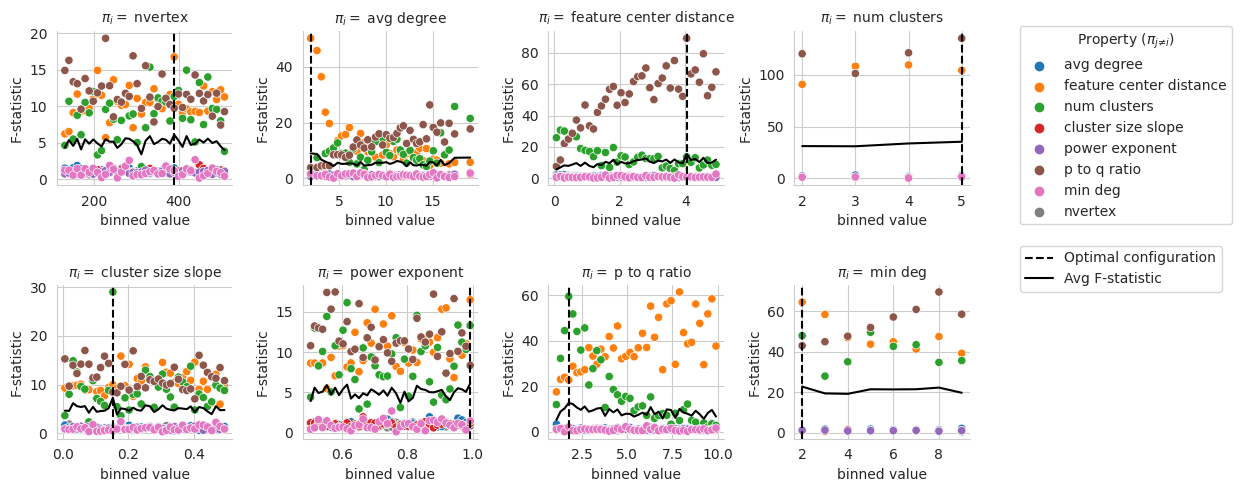

In [20]:
sns.set_style('whitegrid')

g = sns.relplot(data=df_marg.rename(columns={"Property": "Property ($\pi_{j \u2260 i}$)"}), kind="scatter", x="binned value", y="F-statistic", hue="Property ($\pi_{j \u2260 i}$)", 
            col="main-prob", col_wrap=4, facet_kws={'sharey': False, 'sharex': False}, height=2.5, aspect=1, alpha=1)

props = ["nvertex", "avg degree", "feature center distance", "num clusters", "cluster size slope", "power exponent", "p to q ratio", "min deg"]

for ax, p in zip(g.axes.flatten(), props):
    df_temp = df_marg[df_marg['main-prob'] == p]
    p_temp = df_temp.iloc[0]["Property"]
    avg = df_temp[df_temp['Property'] == p_temp]["Avg F-statistic"]
    bins = df_temp[df_temp['Property'] == p_temp]["binned value"]
    ax.axvline(x = df_temp.iloc[0]["Optimal configuration"], color = 'black', label = 'Optimal configuration', linestyle='dashed')
    ax.plot(bins, avg, color='black', label="Avg F-statistic")
    print(p, df_temp.iloc[0]["Optimal configuration"])
g.set_titles("$\pi_i = $ {col_name}") 
sns.move_legend(g, "upper left", bbox_to_anchor=(0.85, 0.955), frameon=True)
plt.subplots_adjust(hspace=0.65, wspace=0.4)
plt.legend(bbox_to_anchor=(2.475, 1.3))
